<br>

#Analysis of the Socio-environmental Situation within the Tagus Basin

**Exploratory Data Analysis, management of rasterised open data and exploration of clustering methods to aid in forming evidence-based solutions to alleviate the drought problems.**

<br>

On the river basin scale, the rivers across the Iberian face different correlated problems that influence the droughts in varying degrees. The Tagus River is a highly documented example.


Despite the Tagus River being the largest in the Iberian Peninsula, spanning across Spain and Portugal, the basin struggles to maintain groundwater levels, contributing to the annual drought problems. The low aquifer recharge and groundwater levels that led to the severe droughts were largely resultant of environmental degradation and exacerbated by social issues within both territories. This situation is often reinforced by community and authority actions and reactions, consequently leading to low outputs from agriculture.


This Exploratory Data Analysis (EDA) is focused on Spain and the country’s open GIS data in 2022, a year before Spain announced that it would no longer completely honour its end of the Albufeira Conventions (Morris et al, 2023). This is with the exception of the data for Potential Productive Land, which 2020 data was used instead as such implicit agricultural data would need lag time for observable impacts. Furthermore, as of the start of this analysis, data collection and processing for 2023 had not yet been complete. This EDA takes into account 5 main factors environmental ‘variables’ that believed to largely contribute to the impact of droughts throughout the region. These will serve as the independent ‘variables’ that were taken from the Copernicus Climate Change Services in the form of raster files.
From existing literature and initial impressions, it appears that social activities – such as agriculture and slash-and-burn – and a combination of other environmental conditions had exacerbated the droughts experienced in Spain. However, the correlation between one independent variable and drought intensity is not often linear as many factors often intermingled with each other and impacting the droughts in a highly complexed way. Different combinations of variables will manifest in different drought intensities and different relationships between them. They would also require contextualised solutions to mitigate these issues within each municipality. Therefore, this EDA will focus on some clustering and regionalisation to help form potential solutions.

<br>

---

<br>

**Independent Variables**
* **Potential Productive Land:** pixels depict the potential value for land to be productive. This is an implicit type of data and is used as a proxy for agricultural activity. The assumption is that agricultural activity will likely happen where there is a high potential of productivity over an area of land. Due to this and the fact that the nature of agricultural activity requires some time for effects to be observed, the dataset for Potential Productive Land will be from 2020, before the year of observation (2022).
* **Estimated Burned Areas:** pixel values in this raster represent probability of an area being burned and detected by satellites across Europe. The fires were likely started for slash-and-burn agriculture and sometimes, these lead to uncontrollable wildfires.
* **Annual Precipitation:** pixels values indicate the average annual precipitation of Europe.
* **Forest Covers:** pixel values indicate the presence of broadleaved and semi-deciduous forests across the Iberian.
* **Soil Permeability:** calculated approximate subsoil water level content was used as a proxy in place of soil permeability. The data from this file was calculated by taking the analysing the different permeability and porosity of different soil types throughout Europe, hence it is used as a proxy to estimate overall soil permeability.

<br>

**Dependent Variables**
* **Combined Drought Indicators (CDI):** pixel values from this raster indicate the intensity of droughts faced by the entire European continent.
* **Relationship between independent variables and CDI**


<br>

---

<br>


As most of the open data files are raster files, this process of the EDA will begin with simple processing of the rasters with the rasterio library. The CDI data, for instance, was obtained as a dataset of 36 raster files that represented the shift in the drought intensities throughout Europe. The average CDI for the entire year of 2022 was calculated in the initial steps.


Thereafter, a mask of the output raster file is made according to each municipality within the Tagus Basin and the total CDI pixels were calculated per unit area of each municipality for a proportionate understanding of the droughts for administrative handling. This is also carried out with the other raster data files that were aforementioned – potential productive land, estimated burned areas, annual precipitation, forest cover and soil permeability – and appended to and overall geodataframe to visualise the situation and manage the overall data.


Some clustering algorithms were tested on the dataset however, means shift clustering and agglomerated clustering were eventually used due to the varying densities of the datasets and a spatially weighted regionalisation of all the variables were made to aid the conception of contextual solutions.







#Connecting to Gdrive, installation and imports

In [ ]:
#Google credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install Pillow
!pip install -U -q PyDrive
!pip install rasterio
!pip install pycrs
!pip install osmnx
!pip install pysal
!pip install cartopy
!pip install esda
!pip install rioxarray
!pip install earthpy

In [ ]:
import numpy as np
import tifffile
import os
import libpysal
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
from pysal.lib import weights
import seaborn as sns
from sklearn import datasets
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

from pysal.explore import esda
from esda.moran import Moran_Local
from esda import Moran
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster

#Rasterio
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio import features
from rasterio.mask import mask

#Combined Drought Indicators (CDI) for Europe
Calculate the average values of every pixel of all .tiff files in "/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/input_data/" folder as an output .tiff file.

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/input_data/'
file_names = os.listdir(dir)

relative_file_paths = []

for file in file_names:
  relative_file_paths.append(os.path.join(dir, file))

In [ ]:
print ('Number of files: {}'.format(len(relative_file_paths)))

Number of files: 36


In [ ]:
for file in relative_file_paths:
  if len(relative_file_paths)%3 == 0:
    aspect_y = 3*2
  else:

    if len(relative_file_paths)%4 == 0:
      aspect_y = 4
    else:

      if len(relative_file_paths)%5 == 0:
        aspect_y = 5
      else:

        if len(relative_file_paths)%7 == 0:
          aspect_y = 7


aspect_x = int(len(relative_file_paths)/aspect_y)

print ('Number of rows: {}'.format(aspect_x), '\nNumber of columns: {}'.format(aspect_y))

Number of rows: 6 
Number of columns: 6


#Show existing CDI rasters in the current dataset

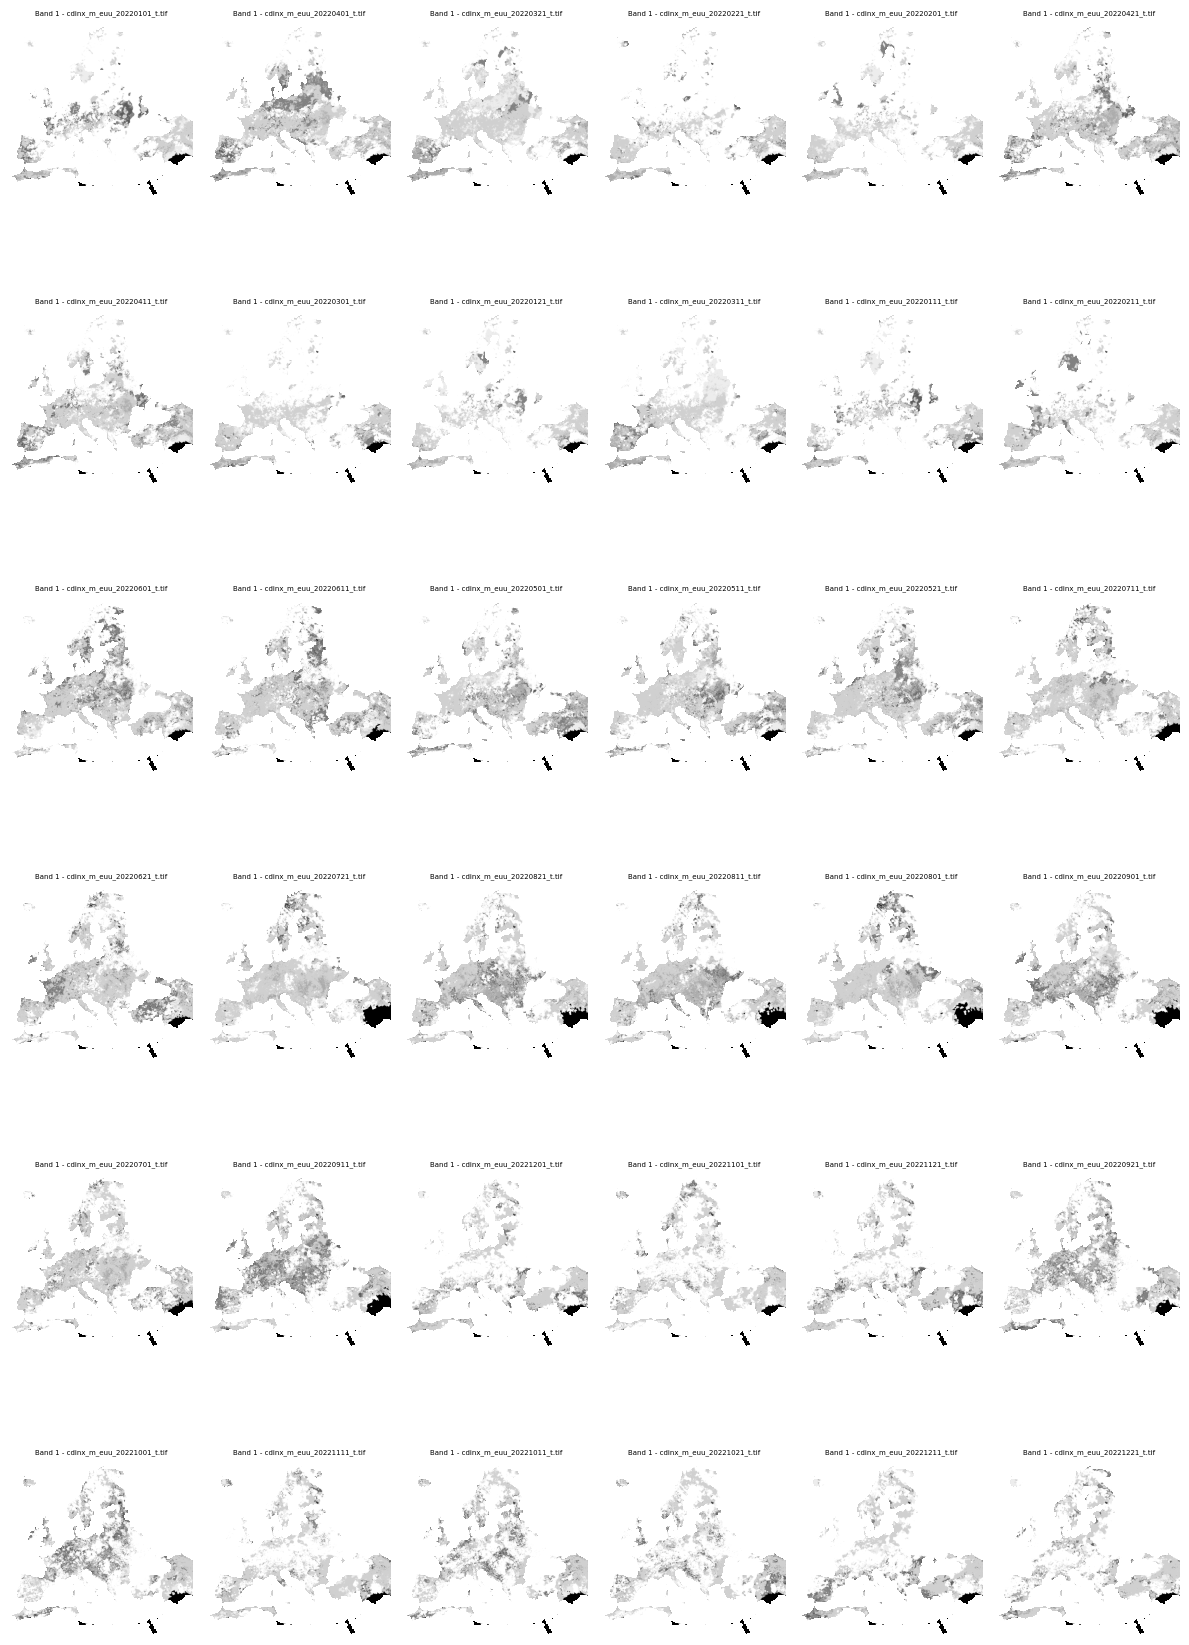

In [ ]:

fig, axs = plt.subplots(aspect_x, aspect_y, figsize=(12, 3*aspect_x))

arr = []

for i, file in enumerate(relative_file_paths):
    with rasterio.open(file) as src:
        image_array = src.read()
        prof = src.profile

        #band 1 for visualization

        flattened_array = image_array[0, :, :].astype('float32')
        arr.append(flattened_array)


        show(flattened_array, ax=axs.flatten()[i], cmap='Greys')

        # Customize plot appearance
        axs.flatten()[i].axis('off')
        axs.flatten()[i].set_title(f'Band 1 - {file.split("/")[-1]}', fontsize=5)


plt.tight_layout()
plt.show()


#Calculate averaged annual CDI for 2022 and output

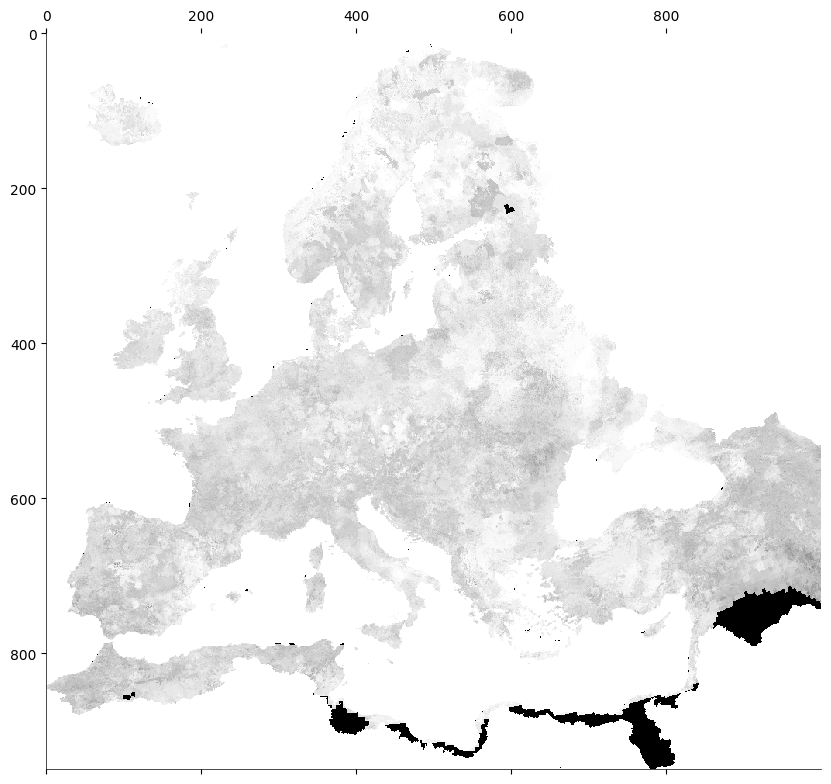

In [ ]:
#calculate mean
array_mean = np.mean(arr, axis=0)

#plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.matshow(array_mean, cmap='Greys')

axs.spines[['top', 'right']].set_visible(False)
axs.spines[['bottom', 'left']].set_linewidth(0.5)

fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.grid(False)

axs.tick_params(axis='both', which='major', labelsize=10)

#Saving with same input CRS

In [ ]:
sample_input_file = relative_file_paths[0]

In [ ]:
CDI_output_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/CDI_mean_output.tiff'

# Get the transform information from the first input file
with rasterio.open(relative_file_paths[0]) as src:
    transform = src.transform

# Save the array_mean as a GeoTIFF file with the same origin point
with rasterio.open(CDI_output_path, 'w', driver='GTiff', height=array_mean.shape[0], width=array_mean.shape[1], count=1, dtype='float32', crs=src.crs, transform=transform) as dst:
    dst.write(array_mean, 1)


#Masking raster files with geometry in shapefiles of Spain

In [ ]:
spain_shp = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/adm_shp_s/adm_shp_s.shp'

spain_gdf = gpd.read_file(spain_shp, crs=from_epsg(3035))

In [ ]:
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
#cdi_data = rasterio.open(CDI_output_path, crs=from_epsg(3035))

cdi_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/CDI_mean_output.tif'
cdi_data = rasterio.open(cdi_path, crs=from_epsg(3035))

prodland_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/land_prod_potential.tif'
prodland_data = rasterio.open(prodland_path, crs=from_epsg(3035))

fire_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/fire_total.tif'
fire_data = rasterio.open(fire_path, crs=from_epsg(3035))

precip_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/precip_mean_output.tif'
precip_data = rasterio.open(precip_path, crs=from_epsg(3035))

forest_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/forests.tif'
forest_data = rasterio.open(forest_path, crs=from_epsg(3035))

soilp_path = '/content/drive/MyDrive/Colab Notebooks/Flowscapes/CDI raster averaging/raster_data/subsoil_water.tif'
soilp_data = rasterio.open(soilp_path, crs=from_epsg(3035))

###getRasterData function

In [ ]:
def getRasterData_s(raster_data, nscale, new_col_str):

  for i in range(len(list(spain_gdf['geometry']))):

    spain_gdf_new = spain_gdf.to_crs(raster_data.crs)
    spain_geo = gpd.GeoDataFrame()
    spain_geo = spain_gdf_new.iloc[[i]].copy()

    out_img, out_transform = mask(dataset=raster_data, shapes=spain_geo['geometry'], crop=True)
    out_img = out_img.astype(np.float64)  #adjust dtype to handle larger values

    sum_pixels = out_img.sum()/spain_gdf['geometry'][i].area *nscale
    spain_gdf.at[i, new_col_str] = sum_pixels

###Get values of rasters

Calculation of pixel values per unit area of municipality. Some variables were scaled so that their values are more manageable in the later stages of the EDA.

In [ ]:
getRasterData_s(cdi_data, 1, 'CDI')

In [ ]:
getRasterData_s(prodland_data, 1, 'productivity')

In [ ]:
getRasterData_s(fire_data, 1/100000000000000000000000000000000000000, 'fires')

In [ ]:
getRasterData_s(precip_data, 10, 'precipitation')

In [ ]:
getRasterData_s(forest_data, 1, 'forests')

In [ ]:
getRasterData_s(soilp_data, 1, 'permeability')

###Check DataFrame

In [ ]:
spain_gdf.head()

INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34070505127      ES   
1  ES.IGN.BDDAE.34073737176      ES   
2  ES.IGN.BDDAE.34024444229      ES   
3  ES.IGN.BDDAE.34081616085      ES   
4  ES.IGN.BDDAE.34074242219      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34070505127   
1  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34073737176   
2  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34024444229   
3  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34081616085   
4  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34074242219   

               NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0               Mijares     ES4    ES41   ES411   
1              Madroñal     ES4    ES41   ES415   
2  Torres de Albarracín     ES2    ES24   ES242   
3           La Frontera     ES4    ES42   ES423   
4                  Yelo     ES4    ES41   ES417   

                                            geometry          CDI  \
0  POLYGON ((-4.87977 40.31357, -4.87862 40.31503...  1510.996739   
1  POLYGON ((-6.07139 40.46751, -6.07018 40.46800...     0.000000   
2  POLYGON ((-1.54490 40.39186, -1.54657 40.39243...  2533.260924   
3  POLYGON ((-2.25892 40.39589, -2.25742 40.39663...  2189.287567   
4  POLYGON ((-2.58949 41.22454, -2.58694 41.22877...  3224.757075   

   productivity          fires  precipitation       forests  permeability  
0  24798.122470 -469554.087210  126273.774338  9.520099e+07  1.012743e+06  
1  29317.287941 -518760.087957   59937.562885  1.598848e+08  6.955998e+05  
2  53253.952737 -317124.150087  214707.744883  8.844550e+07  4.294695e+05  
3  58633.513794 -279327.295317  123357.641993  1.035070e+08  5.521184e+05  
4  56739.133690 -274367.257935  156499.221298  1.089925e+08  9.906310e+05

###Checking if results align with QGIS maps

In [ ]:
spain_gdf.index[spain_gdf['NAMEUNIT'] == 'Aranjuez'].tolist()

[1003]

In [ ]:
spain_gdf.iloc[1003]

INSPIREID                                 ES.IGN.BDDAE.34132828013
COUNTRY                                                         ES
NATLEV           https://inspire.ec.europa.eu/codelist/Administ...
NATLEVNAME                                               Municipio
NATCODE                                                34132828013
NAMEUNIT                                                  Aranjuez
CODNUT1                                                        ES3
CODNUT2                                                       ES30
CODNUT3                                                      ES300
geometry         POLYGON ((-3.8754273070000003 39.910685293, -3...
CDI                                                    2540.744129
productivity                                          43877.982431
fires                                              -1588818.699708
precipitation                                        110228.458398
forests                                           106544015.47

#Visualising environmental issues

####Overview choropleths and Spatial Autocorrelation

Due to the geographic nature of the environmental factors and the following agricultural activities, spatial autocorrelation for most variables will be pressumed based on some assumptions:

* Agricultural activities are most likely to be carried out where there is high land productivity potential.

* Precipitation, forests soil permeability are heavily interlinked to geographical factors such as natural soil composition, weather patterns, temperature and natural terrain conditions.

* The land productivity potential dataset was also determined by analysing environmental conditions such as soil composition, nutrient availability and access to quality water.

* Because of the aforementioned assumptions, it would by extension be rational to assume that the CDI dataset is also spaitally autocorrelated.

<br>

However there are some potential issues that may require an analysis into spatial autocorrelation:

* Since most burned areas are likely caused by slash-and-burn, it is assumed that these areas are also rife with agricultural activity. While this may be driven by geographical factors, there are other reasons too such as simply the availability of unused land which not necessarily have high production potential.

* The resolution of some datasets may be low compared to some sizes of the municipality polygons to get an accurate result from the masking and pixel calculations. Hence there are some values for certain municipalities that are lower than expected.

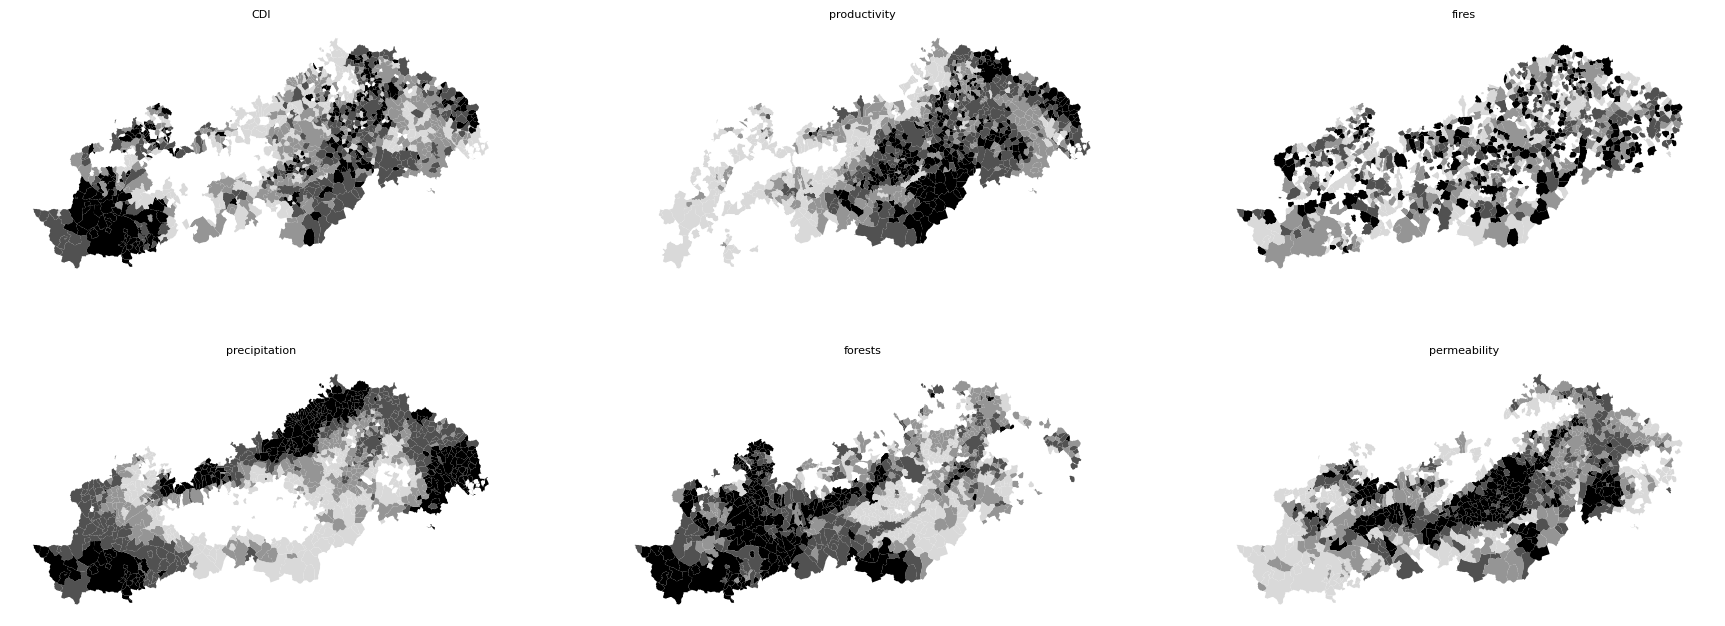

In [ ]:
columns = ['CDI', 'productivity', 'fires', 'precipitation', 'forests', 'permeability']

f, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 8))
axs = axs.flatten()

for i, col in enumerate(columns):
    ax = axs[i]
    spain_gdf.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0.1, cmap='Greys', alpha=1)
    ax.set_axis_off()
    ax.set_title(col, fontsize=8)
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)

plt.show()

#Spatial Autocorrelation

As aforementioned, most burned areas are likely caused by slash-and-burn, according to news reports, it is assumed that these areas are also rife with agricultural activity. Determining the Moran's I values can help understand if there is an overall relevance of geographic location to the occurance of fires. The visualised choropleths also show that there is some degree of spatial autocorrelation and some areas are more significant than others. It is imperative to confirm these.

In [ ]:
%time w = weights.Queen.from_dataframe(spain_gdf, ids='NAMEUNIT')

#row standardize the matrix
w.transform = 'R'
w

CPU times: user 2.54 s, sys: 235 ms, total: 2.78 s
Wall time: 2.79 s


In [ ]:
def spatial_lag(gdf_col, ax):

  sl_col = 'Spatial Lag' + gdf_col
  lag_ = libpysal.weights.spatial_lag.lag_spatial(w, spain_gdf[gdf_col])
  spain_gdf[sl_col] = lag_

  spain_gdf.plot(column=sl_col, cmap='Greys_r', linewidth=0.2, ax=ax, edgecolor='#ffffff', legend=False)
  sm= spain_gdf.plot(column=sl_col, cmap='Greys_r', linewidth=0.2, ax=ax, edgecolor= '#ffffff', legend=False)

  #legend
  ax.set_title(sl_col, fontdict={'fontsize': '5', 'fontweight': '1'})
  cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.015, pad=0.01)
  cbar.ax.tick_params(labelsize=10)
  cbar.outline.set_visible(False)

  ax.set_axis_off()


In [ ]:
def morans_i(gdf_col, ax):
  #check for missing values
  missing_values = spain_gdf[gdf_col].isnull().any()

  if missing_values:
      print("Missing values found. Imputing with mean value.")

      # Impute missing values with mean
      mean_value = np.nanmean(spain_gdf[gdf_col])
      spain_gdf[gdf_col] = spain_gdf[gdf_col].fillna(mean_value)

  #calculate Moran's I
  moran = Moran(spain_gdf[gdf_col], w)
  fig, ax = moran_scatterplot(moran, aspect_equal=False, ax=ax, scatter_kwds={'color': 'grey', 'edgecolor': 'white', 's':5}, fitline_kwds={'color': 'black', 'linewidth': 0.5})

  ax.set_xlabel('Spatial Lag', fontsize=5)
  ax.set_ylabel('Moran\'s I', fontsize=5)

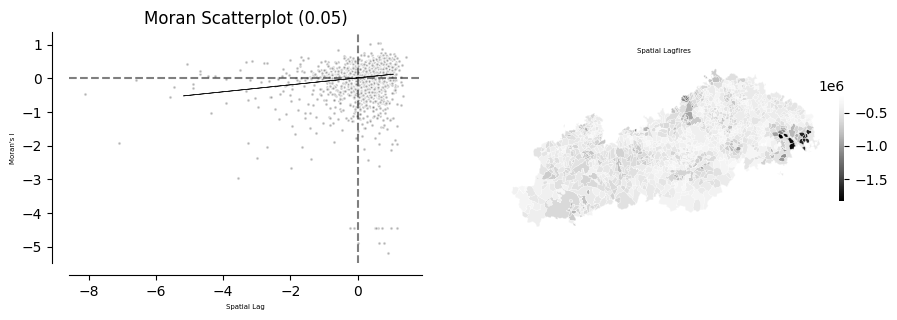

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

morans_i('fires', ax1)
spatial_lag('fires', ax2)

The Moran's I show low global spatial autocorrelation. This means that it's likely that these fires occur not because of their relative location to other fires but rather because of other reasons. The fire data does not appear to have a linear correlation to any of the other variables either. But research has shown that most of these fires are used for deforestation or the clearing of existing vegetation on land that is intended for agriculture. And depending on how these agricultural businesses use these plots of land, deforestation by slash-and-burn can occur seemingly randomly.

In [ ]:
def getLISA1(meas_var, ax):
  std_meas_var = 'std - ' + meas_var
  w_meas_var = 'w - ' + meas_var

  spain_gdf[std_meas_var] = (spain_gdf[meas_var] - spain_gdf[meas_var].mean()) / spain_gdf[meas_var].std()
  spain_gdf[w_meas_var] = weights.lag_spatial(w, spain_gdf[std_meas_var])


  # Plot values
  sns.regplot(x=std_meas_var, y=w_meas_var, data=spain_gdf, ci=None,
              scatter_kws={'s': 5, 'color': 'grey', 'edgecolor': 'white', 'linewidth': 1}, line_kws={'color': 'grey', 'linewidth': 1.5}, ax=ax)

  # Add vertical and horizontal lines
  ax.axvline(0, c='k', alpha=0.2)
  ax.axhline(0, c='k', alpha=0.2)

  ax.text(1.5, 1.5, "HH", fontsize=10)
  ax.text(1.5, -1.5, "HL", fontsize=10)
  ax.text(-1.5, 1.5, "LH", fontsize=10)
  ax.text(-1.5, -1.5, "LL", fontsize=10)

  ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

In [ ]:
def getLISA2(meas_var, ax):

  spain_gdf_temp = pd.DataFrame()
  spain_gdf_temp[meas_var] = spain_gdf[meas_var].copy()

  lisa = esda.Moran_Local(spain_gdf_temp[meas_var], w)
  # Break observations into significant or not
  spain_gdf['significant'] = lisa.p_sim < 0.05
  # Store the quadrant they belong to
  spain_gdf['quadrant'] = lisa.q

  lisa_cluster(lisa, spain_gdf, ax=ax)

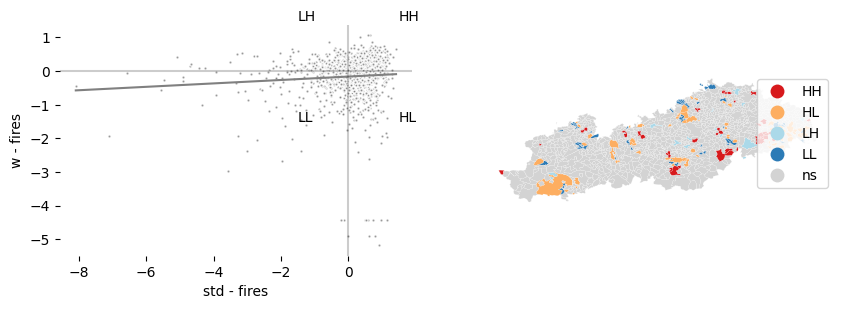

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

getLISA1('fires', ax1)
getLISA2('fires', ax2)

Using the LISA analyses, the significant areas are highlighted. Most of these areas are near the edges of the basin. There appears to be more areas of high values surrounded by high values (HH) and areas of high values surrounded by low values (HL). This observation can be owed to some speculations:

* HH - uncontrollable spread of these fires
* HL - controlled forest burning by businesses that have used up their old land

Despite this, there is reason to rationalise that these fires occur due to a mixture of environmental, social and even business factors related to the agricultural industry. Hence the analysis will proceed with the clustering methods and regionalisation (spatially weighted clustering of variables).

#Means Shift Clustering

Scatterplots of the relationships between the independent variables and the CDI were made to understand how CDI values vary with different values of environmental factors and varying social activities. Visualising this in scatterplots and choropleths will also classify types of regionalisation clusters later.

A few clustering algorithms were used before considering means shift: mainly K-means, DBSCAN and Spectral. The K-means algorithm had difficulty picking up outliers in the scatter and classifying points into approapriate clusters despite using the elbow method and silhouette method to determine the k-value. DBSCAN did not classify the different outliers as the values beyond the main clusters are very sparsely scattered. Spectral regionalisation makes too many clusters within the large main clusters of some plots, making the later regionalisation more complicated.

The Means Shift algorithm, on the other hand, is suitable for cases with shifting densities which is apparent in these datasets, as seen in the pairplots. Hence it was mainly used to analyse the datasets.

In [ ]:
elbow_spain_gdf = pd.DataFrame()

for i in columns:
  elbow_spain_gdf[i] = spain_gdf[i]

In [ ]:
elbow_spain_gdf['fires'] = elbow_spain_gdf['fires'] *-1/100
elbow_spain_gdf['forests'] = elbow_spain_gdf['forests']/1000
elbow_spain_gdf['permeability'] = elbow_spain_gdf['permeability']/1000

In [ ]:
elbow_spain_gdf.head()

CDI  productivity        fires  precipitation        forests  \
0  1510.996739  24798.122470  4695.540872  126273.774338   95200.992087   
1     0.000000  29317.287941  5187.600880   59937.562885  159884.761515   
2  2533.260924  53253.952737  3171.241501  214707.744883   88445.496054   
3  2189.287567  58633.513794  2793.272953  123357.641993  103506.969114   
4  3224.757075  56739.133690  2743.672579  156499.221298  108992.516265   

   permeability  
0   1012.743302  
1    695.599762  
2    429.469487  
3    552.118404  
4    990.630959

In [ ]:
spain_gdf.head()

INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34070505127      ES   
1  ES.IGN.BDDAE.34073737176      ES   
2  ES.IGN.BDDAE.34024444229      ES   
3  ES.IGN.BDDAE.34081616085      ES   
4  ES.IGN.BDDAE.34074242219      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34070505127   
1  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34073737176   
2  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34024444229   
3  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34081616085   
4  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34074242219   

               NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0               Mijares     ES4    ES41   ES411   
1              Madroñal     ES4    ES41   ES415   
2  Torres de Albarracín     ES2    ES24   ES242   
3           La Frontera     ES4    ES42   ES423   
4                  Yelo     ES4    ES41   ES417   

                                            geometry  ...  productivity  \
0  POLYGON ((-4.87977 40.31357, -4.87862 40.31503...  ...  24798.122470   
1  POLYGON ((-6.07139 40.46751, -6.07018 40.46800...  ...  29317.287941   
2  POLYGON ((-1.54490 40.39186, -1.54657 40.39243...  ...  53253.952737   
3  POLYGON ((-2.25892 40.39589, -2.25742 40.39663...  ...  58633.513794   
4  POLYGON ((-2.58949 41.22454, -2.58694 41.22877...  ...  56739.133690   

           fires  precipitation       forests  permeability  Spatial Lagfires  \
0 -469554.087210  126273.774338  9.520099e+07  1.012743e+06     -5.160220e+05   
1 -518760.087957   59937.562885  1.598848e+08  6.955998e+05     -4.203150e+05   
2 -317124.150087  214707.744883  8.844550e+07  4.294695e+05     -1.635850e+06   
3 -279327.295317  123357.641993  1.035070e+08  5.521184e+05     -3.360764e+05   
4 -274367.257935  156499.221298  1.089925e+08  9.906310e+05     -4.596652e+05   

   std - fires  w - fires  significant  quadrant  
0     0.138417  -0.043945        False         4  
1    -0.054691   0.331653        False         2  
2     0.736622  -4.438670         True         4  
3     0.884955   0.662245         True         1  
4     0.904420   0.177225        False         1  

[5 rows x 21 columns]

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def getMS(ms_col_0, ms_col_1, c, q, s, a):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 5))

    db_spain_gdf = elbow_spain_gdf[[ms_col_0, ms_col_1]]

    X = db_spain_gdf.values
    X = StandardScaler().fit_transform(X)

    bandwidth = estimate_bandwidth(X, quantile=q, n_samples=s)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print("number of estimated clusters : %d" % n_clusters_)

    #clustering scatterplot
    ax1.scatter(X[:, 0], X[:, 1], c=labels, cmap=c, s=5, alpha=a)

    ax1.set_title("Estimated number of clusters: %d" % n_clusters_)

    #cluster labels in spain_gdf
    spain_gdf['Cluster_' + ms_col_0 + '_' + ms_col_1] = ms.labels_

    #choropleth map
    spain_gdf.plot(column='Cluster_' + ms_col_0 + '_' + ms_col_1, cmap=c, linewidth=0.1, ax=ax2, edgecolor='white', alpha = a)

    ax2.set_title('MeanShift Clustering on Choropleth Map')

    ax1.spines[['top', 'right']].set_visible(False)
    ax1.spines[['bottom', 'left']].set_linewidth(0.8)

    ax2.spines[['top', 'right']].set_visible(False)
    ax2.spines[['bottom', 'left']].set_linewidth(0.8)

    ax1.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.3)

    plt.show()


#Means Shift outputs

number of estimated clusters : 10


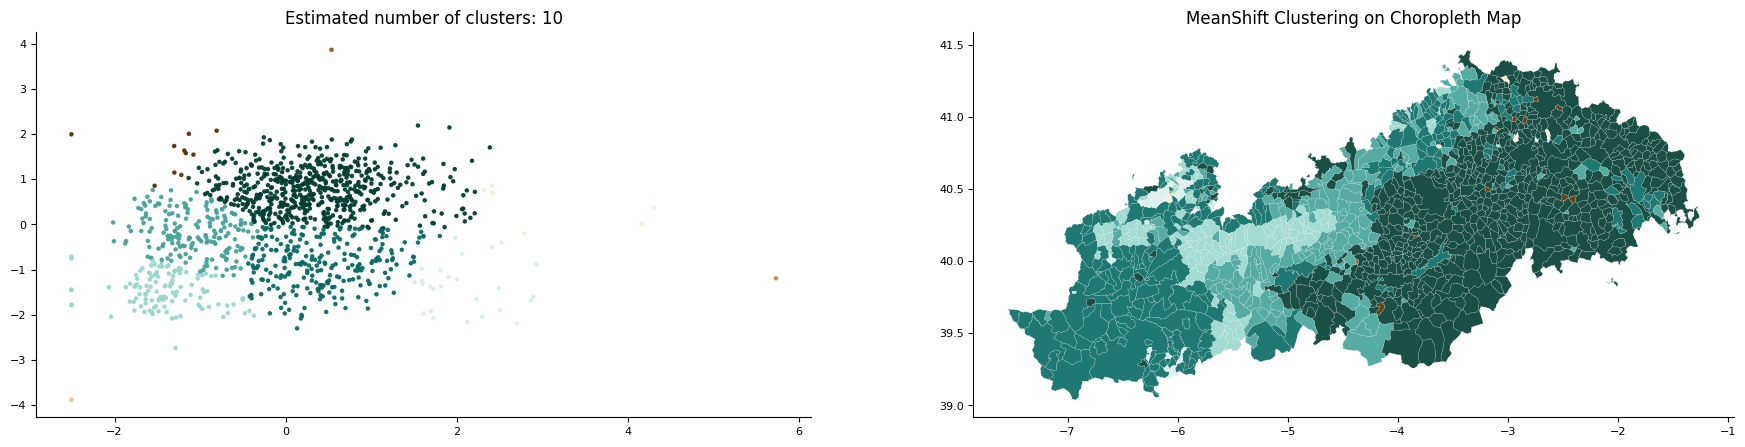

In [ ]:
getMS('CDI', 'productivity', 'BrBG_r', 0.1, 1000, 0.9)

number of estimated clusters : 17


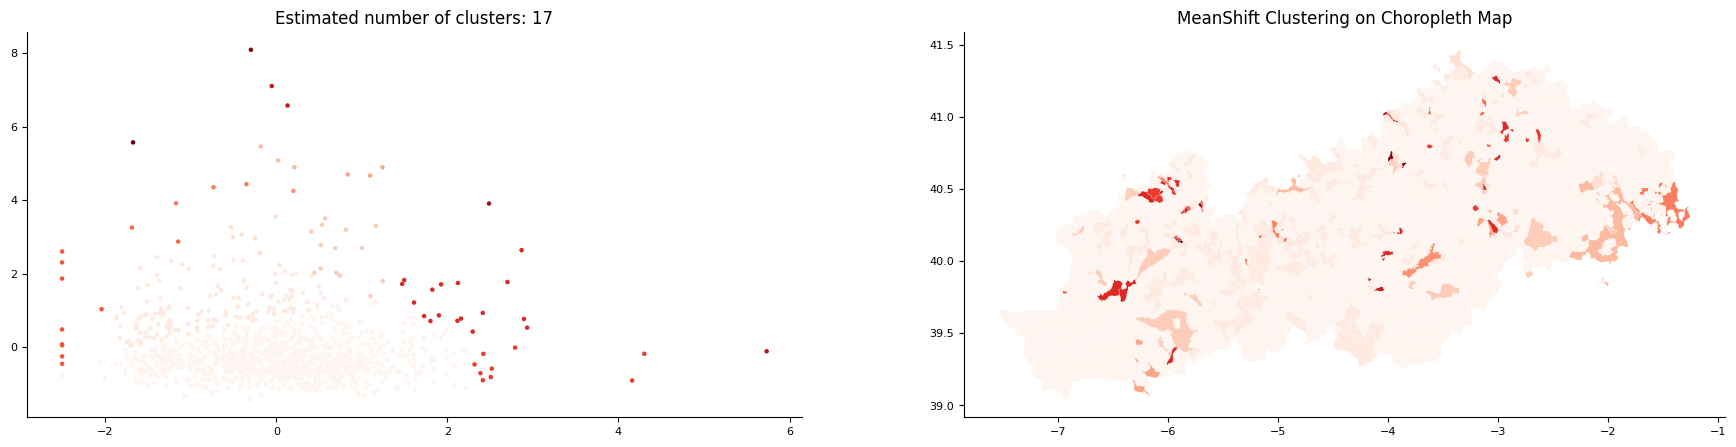

In [ ]:
getMS('CDI', 'fires', 'Reds', 0.1, 1000, 1)

The typical assumption is that with high burned areas, vegetation will struggle to regrow, or land will be used for agriculture, making the land less permeable for water infiltration that will result in high drought intensity. However, there is not a clear correlation between high amount of burned areas per municipality and CDI value per municipality. Despite the scattered results, there are a few groups of outliers worth noting:

1. High burned areas and corresponding low CDI
2. High burned areas and corresponding high CDI
3. High burned areas and corresponding moderate CDI
4. Moderate burned areas and corresponding high CDI
5. Low burned areas and corresponding high CDI

number of estimated clusters : 10


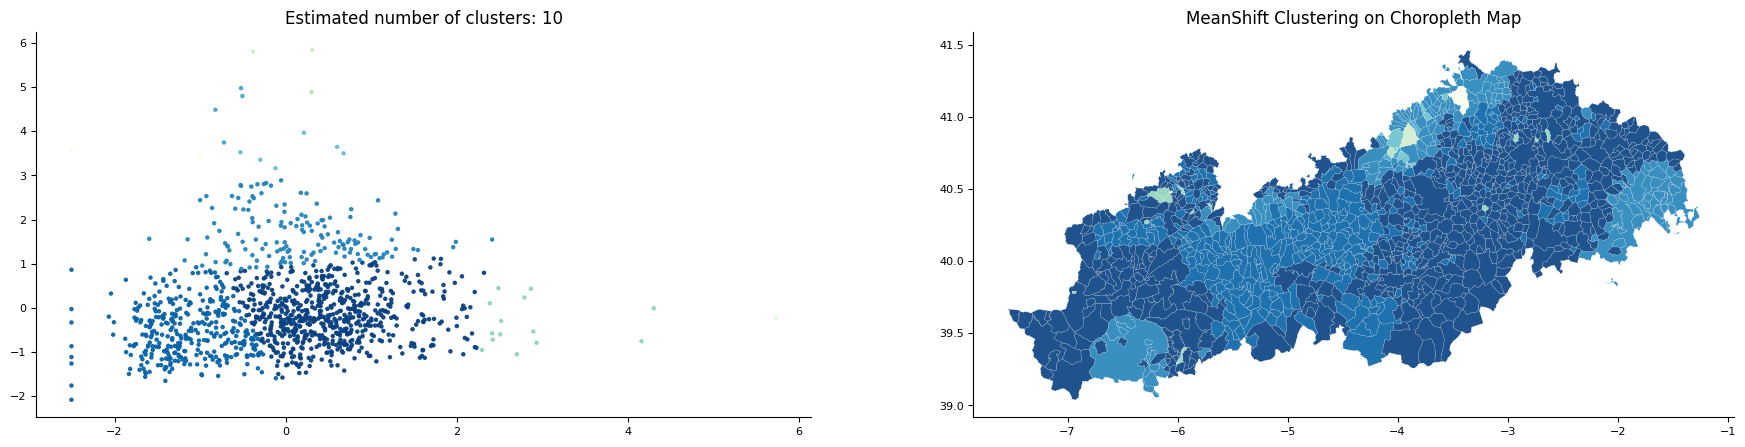

In [ ]:
getMS('CDI', 'precipitation', 'GnBu_r', 0.1, 1000, 0.9)

The general assumption is that with high rainfall and precipitation over an area, lower drought intensity should be observed but unexpectedly, this is not the relationship between average precipitation and CDI. There is also not a clear correlation. However, the outliers seem to follow a low positive correlation of high precipitation and high CDI values. It is unexpected but there are other anomalies also worth noting:

1. High average precipitation and corresponding high CDI
2. High average precipitation and corresponding moderate CDI
3. Moderate average precipitation and corresponding high CDI
4. Low average precipitation and corresponding low CDI

number of estimated clusters : 6


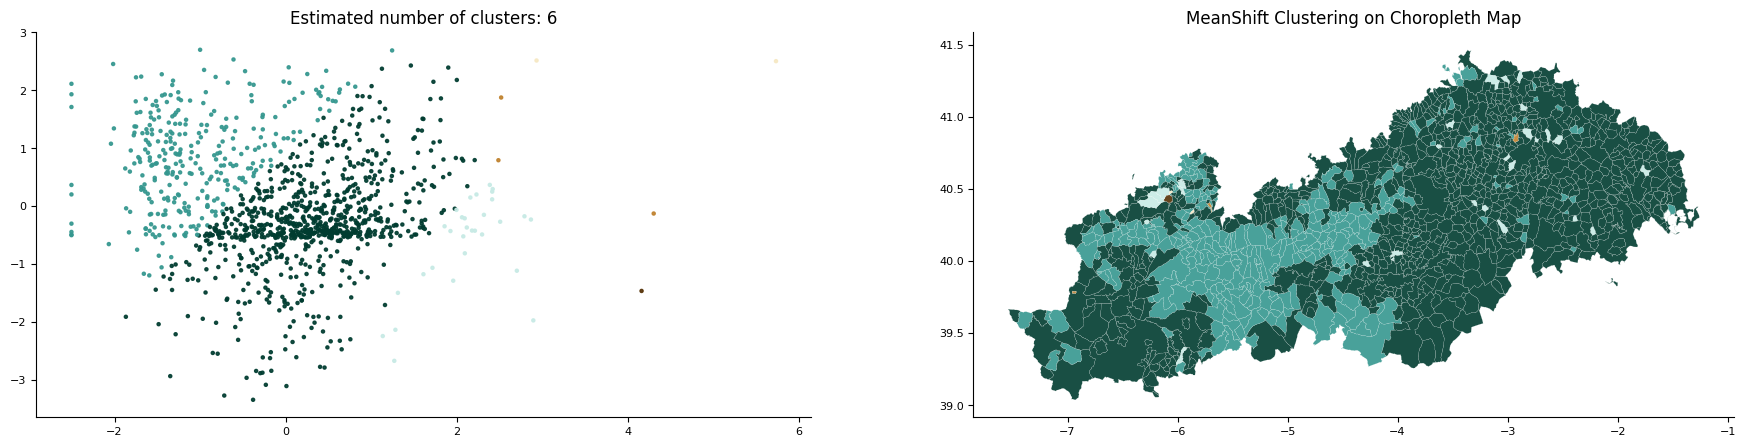

In [ ]:
getMS('CDI', 'forests', 'BrBG_r', 0.1, 1000, 0.9)

There is also not a clear correlation between the amount of forest cover and CDI values. The scatterplot for this relationship is much more sparse than the previous analyses and there are far more 'anomalies' that belong to low density clusters, away from the main cluster. There are no clear trends to the outliers either but some unexpected clusters can give more insights:

1. High forest covers and corresponding high CDI
2. High forest covers and corresponding moderate CDI
3. Moderate forest covers and corresponding high CDI
4. Low forest covers and corresponding low CDI

number of estimated clusters : 8


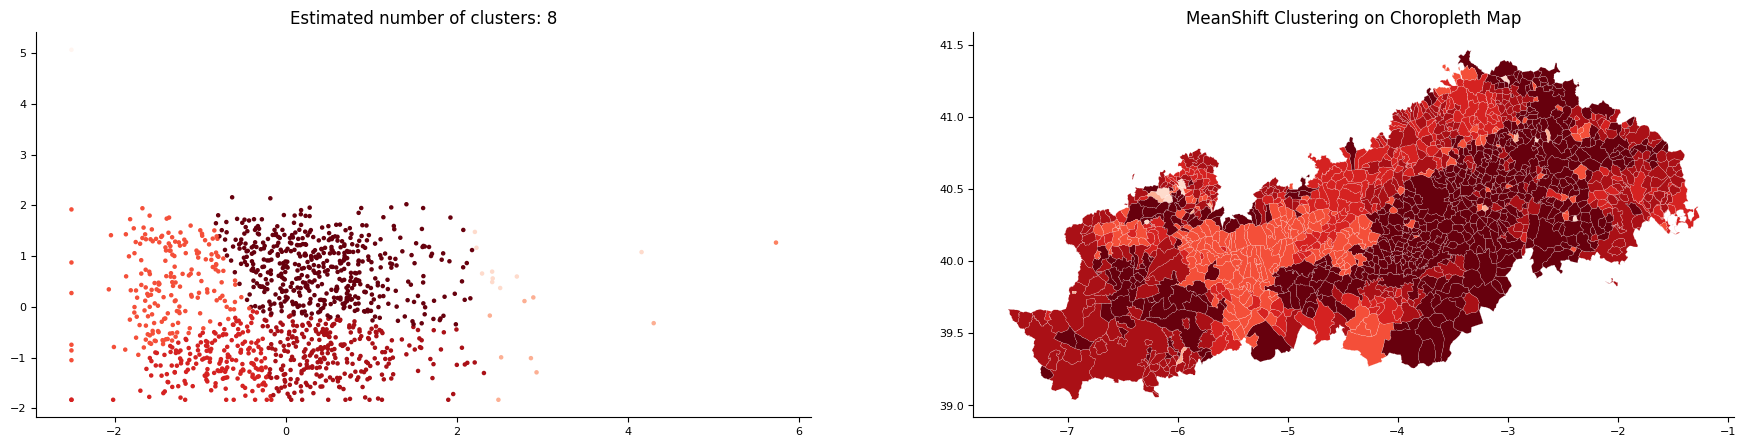

In [ ]:
getMS('CDI', 'permeability', 'Reds_r', 0.1, 1000, 1)

An area with high soil permeability should expect high levels of water infiltration and hence low drought intensity. This relationship does show a more orderly trend between the soil permeability and CDI values which is possibly owed to the calculated (and not observed) nature of the dataset values. Despite this, there are also points worth noting.

1. High soil permeability and corresponding high CDI
2. High soil permeability and corresponding moderate CDI
3. Moderate soil permeability and corresponding high CDI
4. Low soil permeability and corresponding low CDI

#Regionalisation: Agglomerated Clustering

As environmental variables and variables of social activity linked to environmental conditions are taken into consideration, a clustering algorithm that accounts for the spatial autocorrelation of datasets should be used as part of the analysis.

Agglomerative Hierarchal Clustering was applied here with the consideration of spatial weights per municipality. This will be referred to as Regionalisation. As environmental factors of a municipality will likely affect its neighbours, when considering appropriate solutions to the drought problems, neighbours should always be taken into account as environmental systems do not adhere to administrative boundaries and are often interconnected.

Agglomerative Hierarchal Clustering was used as there is no need to first dictate the initial number of clusters. That was easily accomplished with the depiction of the dendrogram. It was helpful to categorise all municipalities based on similar combinations of values for each varaible. However, the heirarchal nature of the dendrogarm may not be suitable for the predetermination of the number of clusters.

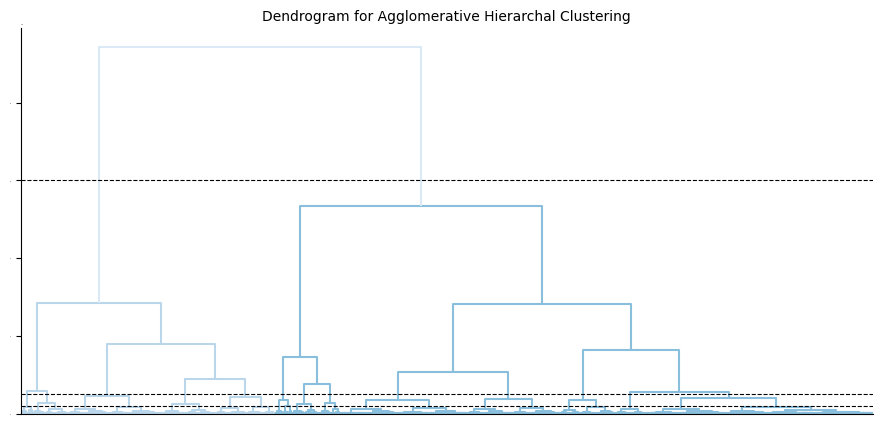

In [ ]:
import scipy.cluster.hierarchy as shc

reg_spain_gdf = spain_gdf[['CDI', 'productivity', 'fires', 'precipitation', 'forests', 'permeability']]

mpl.rcParams['font.size'] = 0

scaler = StandardScaler()
reg_spain_gdf_scaled = scaler.fit_transform(reg_spain_gdf)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 5))
ax.set_title('Dendrogram for Agglomerative Hierarchal Clustering', fontsize=10)
dend = shc.dendrogram(shc.linkage(reg_spain_gdf, method='ward'))

plt.axhline(y = 600000000, color = 'black', linestyle = '--', linewidth=0.8)
plt.axhline(y = 0.5*100000000, color = 'black', linestyle = '--', linewidth=0.8)
plt.axhline(y = 0.2*100000000, color = 'black', linestyle = '--', linewidth=0.8)

plt.xticks([])

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_linewidth(0.8)
ax.grid(False)

sns.set_palette('Blues')

While the dendrogam depicts n_clusters to be 2, it is obvious that at lower levels, it is possible to have more differentiation. It is also imperative to note that over-generalising for a large area with a large dataset can be harmful for forming solutions. Therefore, despite this larger cluster numbers will be tested out to distinguish different conditions across the basin.

Three lines were plotted to consider other n_clusters values:
* y=6*1e8: n_clusters=2
* y=2*1e7: n_clusters=25
* y=5*1e7: n_clusters=13

In [ ]:
from matplotlib.colors import ListedColormap
regional_colours = ['#66000e', '#cc171c', '#f86949', '#fdbaa0', '#01451c', '#238a45', '#64c3a3', '#0b3e80', '#2a8cbd', '#7dcac4', '#d0ebca']
reg_cmap = ListedColormap(regional_colours)
reg_cmap_r = reg_cmap.reversed()

In [ ]:
def aggcls_w(ax, n_cls, df, sn):
  w = weights.Queen.from_dataframe(spain_gdf, use_index=False)
  agg_clus = cluster.AgglomerativeClustering(n_clusters=n_cls, connectivity=w.sparse)

  # Seed setup
  np.random.seed(sn)
  agg_clus = agg_clus.fit(df[columns])

  df['agg_clustering'] = agg_clus.labels_

  df.plot(column='agg_clustering', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax, cmap=reg_cmap_r)

  ax.spines[['top', 'right']].set_visible(False)
  ax.spines[['bottom', 'left']].set_linewidth(0.8)
  ax.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.2)

  ax.set_title('Regionalisation of Envrionmental Variables, n_clusters = ' + str(n_cls), fontsize=10)

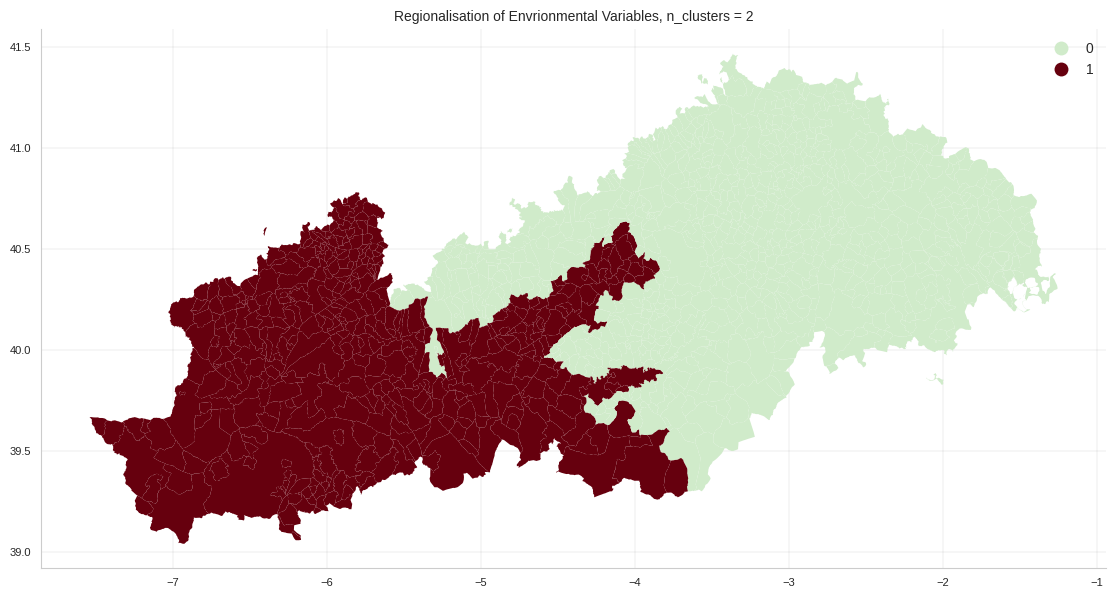

In [ ]:
f, ax = plt.subplots(nrows=1, figsize=(25, 7))

aggcls_w(ax, 2, spain_gdf, 1506)

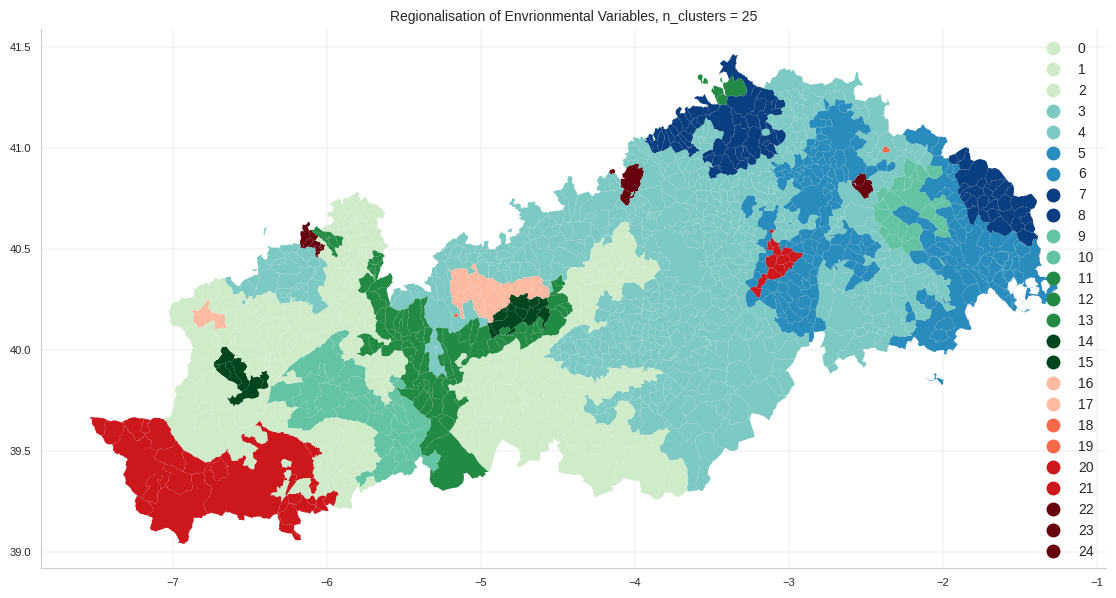

In [ ]:
f, ax = plt.subplots(nrows=1, figsize=(25, 7))

aggcls_w(ax, 25, spain_gdf, 1366)

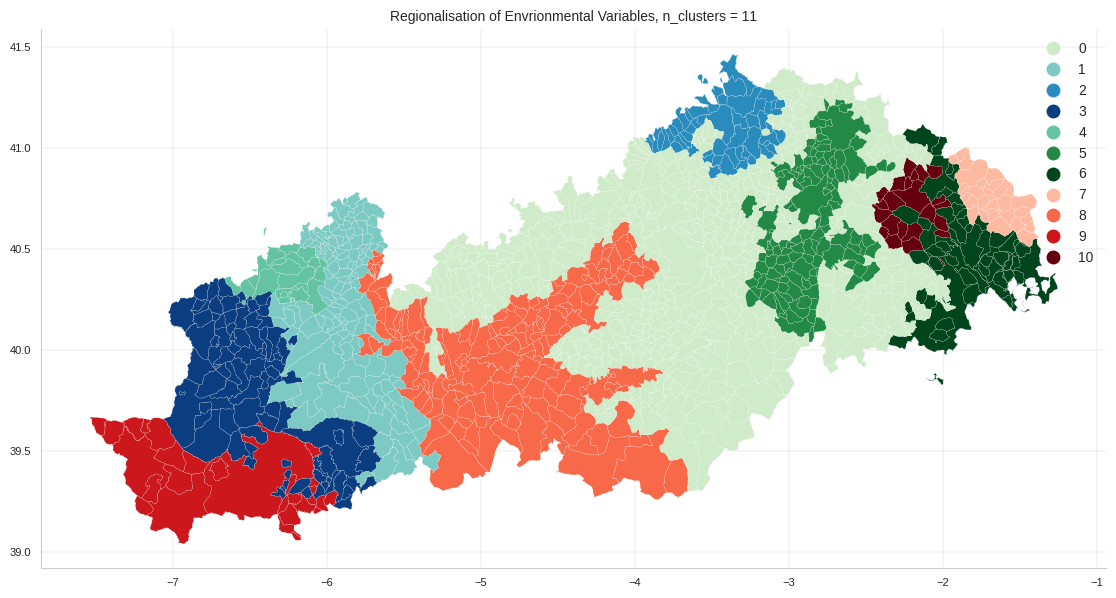

In [ ]:
f, ax = plt.subplots(nrows=1, figsize=(25, 7))

aggcls_w(ax, 11, spain_gdf, 4343)

3 clustesrs make the regions seem to generalised. Other numbers of clusters were tested to see what kind of regions they create.

With 25 clusters, there seems to be too much differentiation around the edges of the river basin and not the rest, presenting many 'anomalies'. This translates to the areas in the middle of the basin being more similar to each other in terms of conditions.

With 13 clusters, the aforementioned anomalies disappear while staying similarly grouped as the large clusters of n_clusters=25. It is also interesting to note that the border between region 1 and region 2 from the original n_clusters=3 plot remained the same in all 3 cases. This means that the conditions of the municipalities belonging to their respective regions are very distinct from each other.

Observation of different n_clusters.
* y=6*1e8: the original recommended number of n_clusters is 2 as below the line of the highest order of the dendrogram, the data can be summarised into 2 major clusters. However, this is too much of a generalised result.
* y=2*1e7: below this line, there are about 25 clusters. However, the clusters shown on the maps depict too many outliers that are too similar to larger clusters in variable values.
* y=5*1e7: below this line are about 13 clusters. There are still a few outliers but they are reasonably distinct from the larger clusters - which is more appropriate than the previous n_clusters. Hence, the project will continue with this value.

#High Drought Intensity of Region 0

Region 0 has a combination of:
* **High CDI values**
* High land productivity potential
* High initial soil permeability
* Mid - Low precipitation
* Mid - Low forests

It's highly possible that this region is highly involved in agricultural activity. Most agricultural activities form vast lands of monospecific crops, reducing the biodiversity of the area around it. This often leads to low natural vegetation regeneration and low soil permeability in a long run. When water infiltration is low, groundwater cannot be recharged efficiently enough, causing this region to be vulnerable to extended droughts during dry seasons. And it is observed with the 2022 CDI data that this region does experience high drought intensity.

To make a comparative observation, region 8 has:
* **Low CDI values**
* Low land productivity potential
* High initial soil permeability
* Mid levels of precipitation
* High forest densities

A major difference between the two are:
1. The high pressence of forests in region 8 and low pressence of forests in region 0
2. The implications of low agricultural activity in region 0 that comes with low land productivity potential (as the land is occupied by forests) compared to region 0 where there is high land productivity potential but little to no forests.

To move forward towards the alleviation of droughts, a recommendation of introducing forest growth in some areas of region 0 and alternative sustainable agricultural methods such as land-sparing and land-sharing. Land-sharing as a solution can come hand-in-hand with forest-growing initiatives by interspesing forest land between agricultural land to reintroduce biodiversity and maintain a level of water content around the area.

In [ ]:
spain_gdf[['NAMEUNIT', 'agg_clustering']]

NAMEUNIT  agg_clustering
0                           Mijares               0
1                          Madroñal               1
2              Torres de Albarracín               6
3                       La Frontera               0
4                              Yelo               0
...                             ...             ...
1167          Villavieja del Lozoya               2
1168                      Zarzalejo               0
1169  Lozoyuela-Navas-Sieteiglesias               0
1170                 Puentes Viejas               0
1171                    Tres Cantos               0

[1172 rows x 2 columns]

In [ ]:
spain_gdf_0 = spain_gdf[spain_gdf['agg_clustering'] == 0].copy()

spain_gdf_0.reset_index(drop=True, inplace=True)

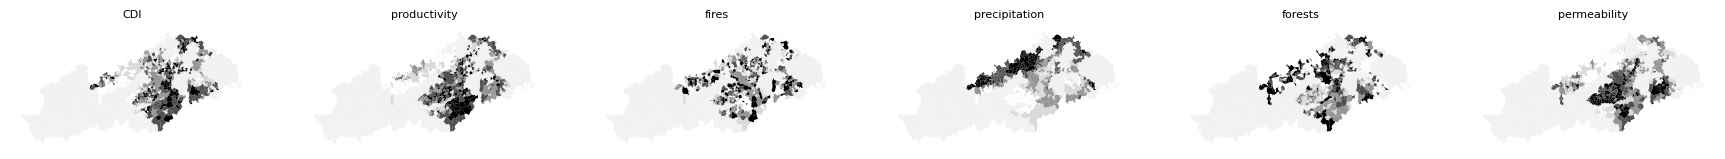

In [ ]:
columns = ['CDI', 'productivity', 'fires', 'precipitation', 'forests', 'permeability']

f, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(22, 10))
axs = axs.flatten()

for i, col in enumerate(columns):
    ax = axs[i]
    ax = spain_gdf.plot(ax=ax, color='grey', edgecolor='#ffffff', linewidth = 0.1, alpha=0.1)
    ax = spain_gdf_0.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0.1, cmap='Greys', alpha=1)
    ax.set_axis_off()
    ax.set_title(col, fontsize=8)
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)

plt.show()

In [ ]:
def Rec_part1(df, col, ax, c, title):
  ax = spain_gdf.plot(ax=ax, color='grey', edgecolor='#ffffff', linewidth=0, alpha=0.1)
  ax = df.plot(column=col, ax=ax, edgecolor='#ffffff', scheme='Quantiles', linewidth=0.1, cmap=c, alpha=1)
  ax.set_axis_off()
  ax.set_title(title, fontsize=8)
  ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)


The pixel values of each variable, apart from CDI, are scaled down so that each variable would hold about the same weight as other variables.

In [ ]:
spain_gdf_0['permeability'] = spain_gdf_0['permeability']/100
spain_gdf_0['precipitation'] = spain_gdf_0['precipitation']/1000
spain_gdf_0['forests'] = spain_gdf_0['forests']/1000
spain_gdf_0['productivity'] = spain_gdf_0['productivity']/100

* **prio_gw_recharge:** Shows the areas placed on a scale of priority to push resources into improving groundwater recharge. Typically, high priority areas are those wih low soil permeability with low precipitation and high CDI values.

* **prio_forest_growing:** Shows the areas placed on a scale of priority to push resources into growing forests. Typically, high priority areas are those with low soil permeability, low amount of forest covers and high CDI values.

* **prio_land_s:** Shows the areas placed on a scale of priority to push resources into growing forests. Typically, high priority areas are those with low soil permeability, high intensive agriculture and high CDI values.

In [ ]:
def getMS2(gdf ,ms_col_0, ms_col_1, c, q, s, a):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 5))

    db_spain_gdf = gdf[[ms_col_0, ms_col_1]]

    X = db_spain_gdf.values
    X = StandardScaler().fit_transform(X)

    bandwidth = estimate_bandwidth(X, quantile=q, n_samples=s)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print("number of estimated clusters : %d" % n_clusters_)

    #clustering scatterplot
    ax1.scatter(X[:, 0], X[:, 1], c=labels, cmap=c, s=5, alpha=a)

    ax1.set_title("Estimated number of clusters: %d" % n_clusters_)

    #cluster labels in spain_gdf
    gdf['Cluster_' + ms_col_0 + '_' + ms_col_1] = ms.labels_

    #choropleth map
    gdf.plot(column='Cluster_' + ms_col_0 + '_' + ms_col_1, cmap=c, linewidth=0.1, ax=ax2, edgecolor='white', alpha = a)

    ax2.set_title('MeanShift Clustering on Choropleth Map')

    ax1.spines[['top', 'right']].set_visible(False)
    ax1.spines[['bottom', 'left']].set_linewidth(0.8)

    ax2.spines[['top', 'right']].set_visible(False)
    ax2.spines[['bottom', 'left']].set_linewidth(0.8)

    ax1.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.3)

    plt.show()

In [ ]:
spain_gdf_0['prio_gw_recharge'] = spain_gdf_0['CDI'] - spain_gdf_0['permeability'] - spain_gdf_0['precipitation']

In [ ]:
spain_gdf_0['prio_forest_growing'] = spain_gdf_0['CDI'] - spain_gdf_0['permeability'] - spain_gdf_0['forests']

number of estimated clusters : 17


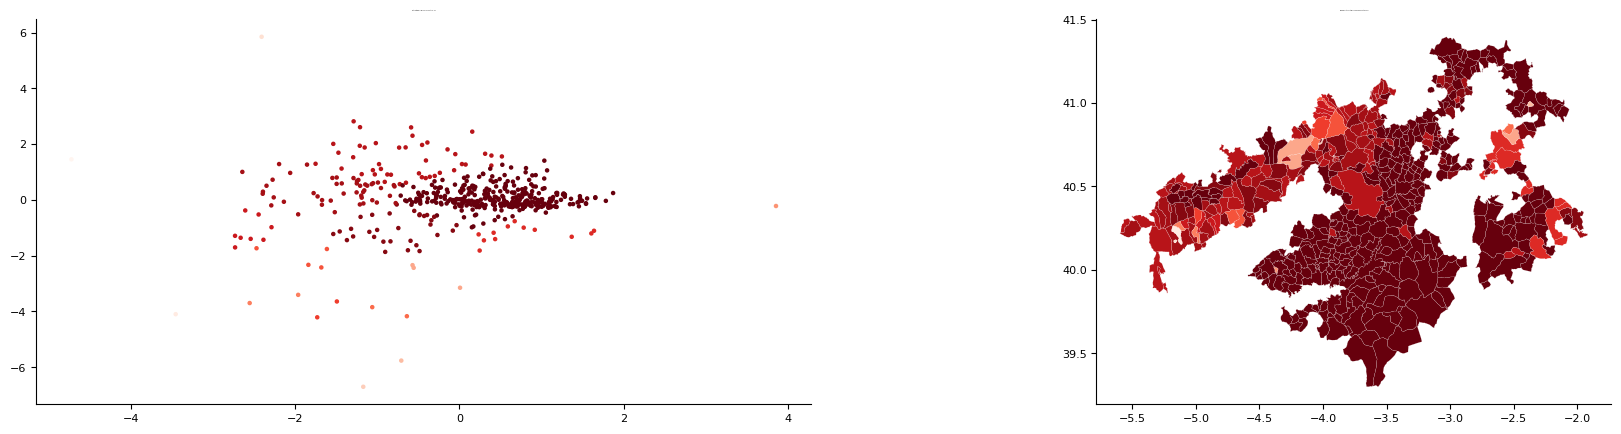

In [ ]:
getMS2(spain_gdf_0, 'productivity', 'forests', 'Reds_r', 0.1, 1000, 1)
#'Cluster_' + ms_col_0 + '_' + ms_col_1

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


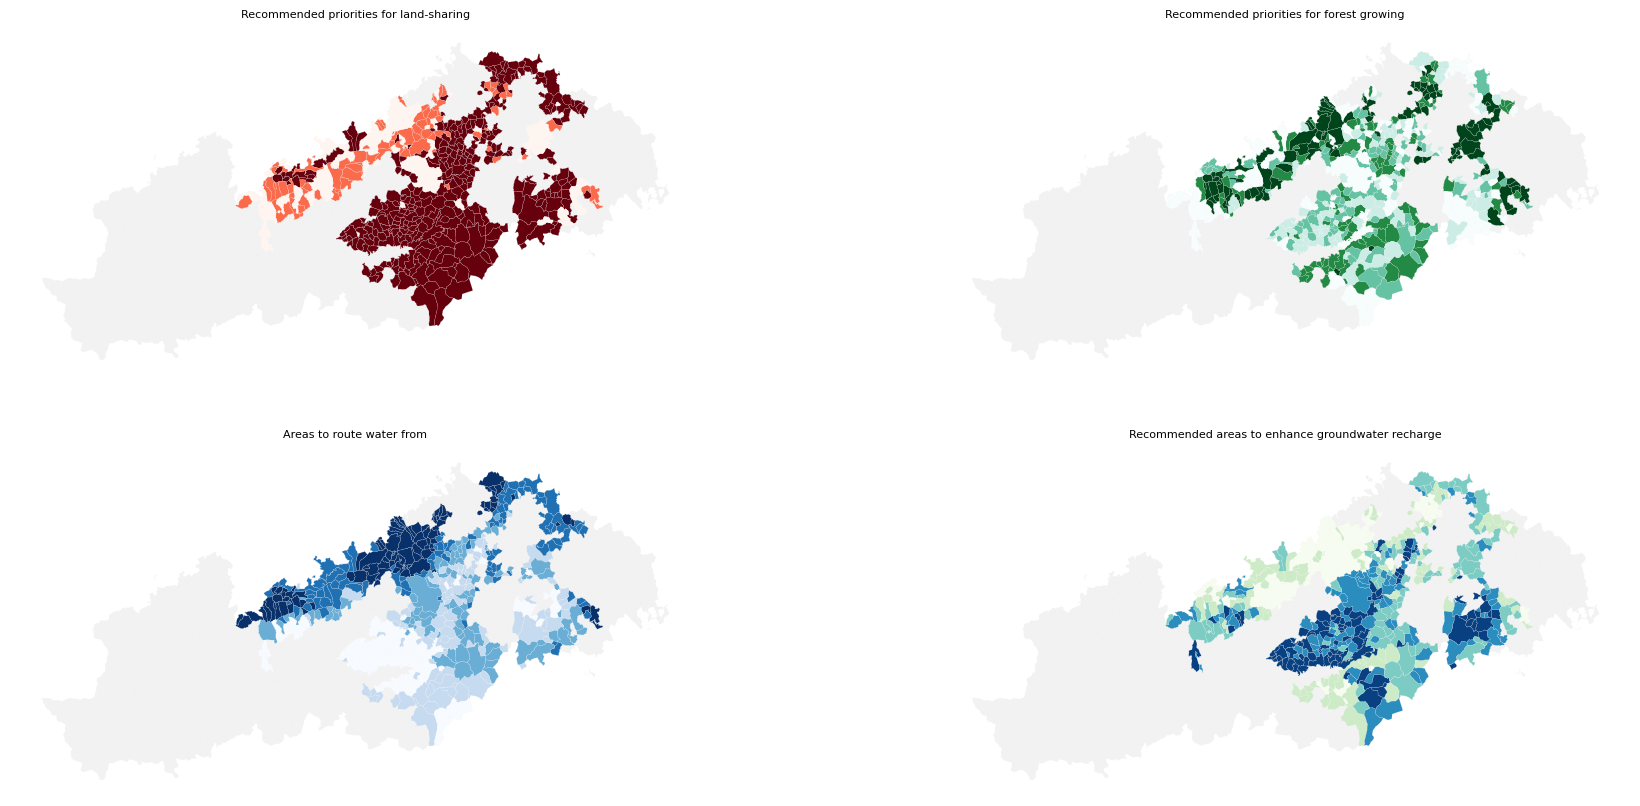

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(22, 10))

Rec_part1(spain_gdf_0, 'Cluster_productivity_forests', ax1, 'Reds_r', 'Recommended priorities for land-sharing')
Rec_part1(spain_gdf_0, 'prio_forest_growing', ax2, 'BuGn', 'Recommended priorities for forest growing')
Rec_part1(spain_gdf_0, 'precipitation', ax3, 'Blues', 'Areas to route water from')
Rec_part1(spain_gdf_0, 'prio_gw_recharge', ax4, 'GnBu_r', 'Recommended areas to enhance groundwater recharge')

The conclusion to this brief analysis of Spain's open data related to its drought situation are these recommended priority levels for different administrations to direct resources to land-sharing and forest growth. However, there is a deeper socio-economic and cultural context behind Spain's struggle with the climate crisis and this is further explored in the main graduation thesis this analysis is aiding, entitled 'Evolutionary Systems: An Adaptable Waterscape Commons for the Tagus River Basin'. This graduation thesis is not yet complete, thus solutions and further recommendations will be more appropriately elaborated there.